In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from lib.models import ResNetClassifier, ResBlock
from torch import nn
from lib.data.dataloading import load_nursing
from pathlib import Path
from lib.modules import optimization_loop
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from lib.utils import plot_and_save_cm
import seaborn as sns
from tabulate import tabulate


In [39]:
nursing_raw_dir = Path("/home/musa/datasets/nursingv1")
nursing_label_dir = Path("/home/musa/datasets/eating_labels")
DEVICE = 'cuda:1'

In [73]:
winsize = 1001
nursing_trainloader, nursing_testloader = load_nursing(
    nursing_raw_dir, 
    nursing_label_dir, 
    winsize=winsize, 
    # session_idxs=[50,52],
    n_sessions=6, 
    test_size=0.5, 
    batch_size=512,
    shuffle_test=True
)

Selected sessions: [52, 13, 40, 44, 69, 11]
Train sessions: [44, 69, 13] - total length: 475000
Test sessions: [40, 11, 52] - total length: 419000


In [89]:
model = ResNetClassifier(winsize, 3, (4,4)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

4309


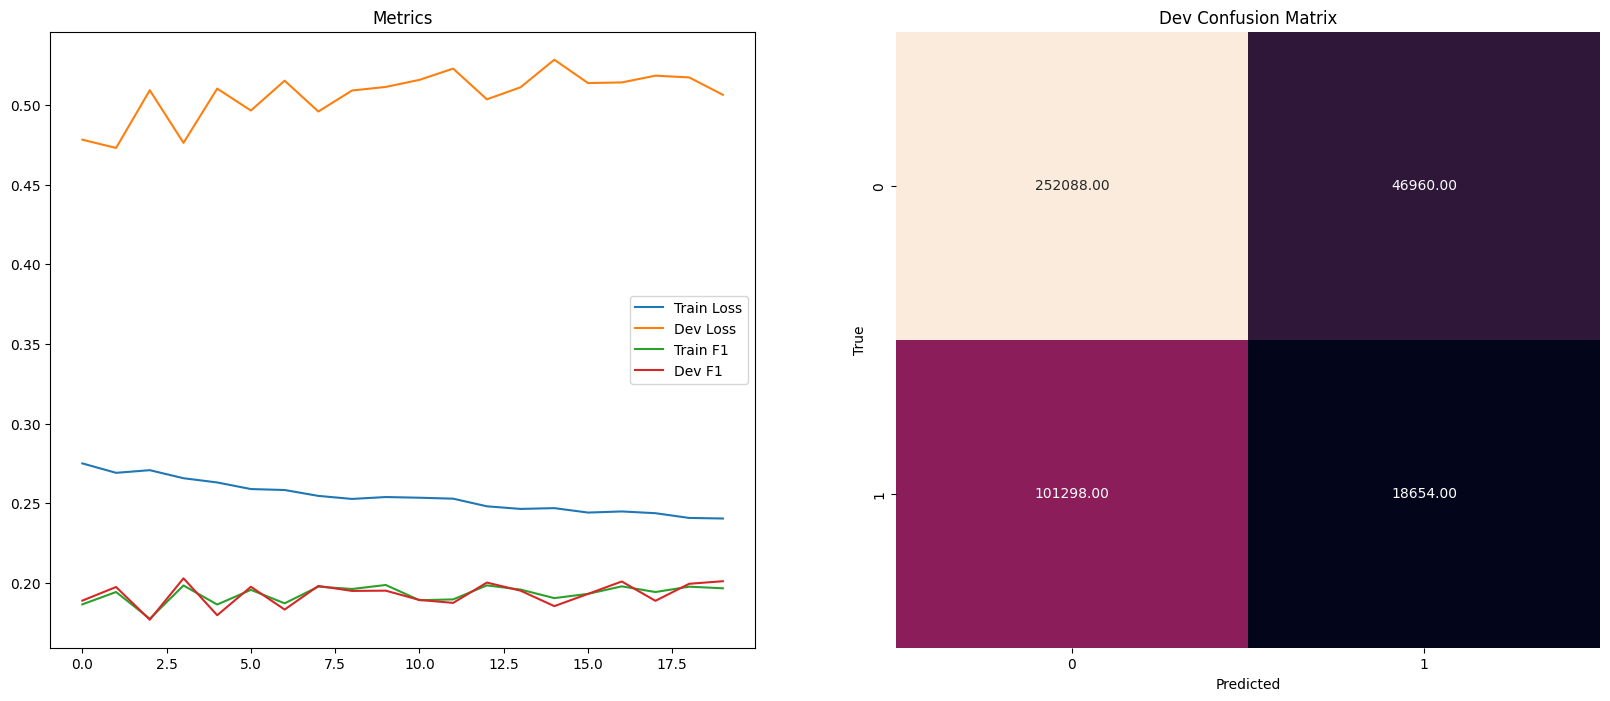

In [92]:
# optimization_loop(model, nursing_trainloader, nursing_testloader, criterion, optimizer, 10, DEVICE)

train_loss_batch = []
test_loss_batch = []
confs = []
train_stats = {'loss': [], 'prec': [], 'recall': [], 'f1score': []}
test_stats = {'loss': [], 'prec': [], 'recall': [], 'f1score': []}

for epoch in range(20):
    model.train()
    for X,y in nursing_trainloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    model.eval()
    loss = 0
    ypred = []
    for X,y in nursing_trainloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss_i = criterion(logits, y).item()
        train_loss_batch.append(loss_i)
        loss += loss_i
        ypred += torch.round(torch.sigmoid(logits.detach().cpu())).tolist()
    train_stats['loss'].append(loss / len(nursing_trainloader))
    prec, recall, f1score, _ = precision_recall_fscore_support(
        nursing_trainloader.dataset.y.squeeze(), 
        ypred, 
        zero_division='warn', pos_label=1, average='binary'
    )
    train_stats['prec'].append(prec)
    train_stats['recall'].append(recall)    
    train_stats['f1score'].append(f1score)

    loss = 0
    test_ypred = []
    for X,y in nursing_testloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss_i = criterion(logits, y).item()
        test_loss_batch.append(loss_i)
        loss += loss_i
        test_ypred += torch.round(torch.sigmoid(logits.detach().cpu())).tolist()
        confs += torch.sigmoid(logits.detach().cpu()).tolist()

    test_stats['loss'].append(loss / len(nursing_testloader))
    prec, recall, f1score, _ = precision_recall_fscore_support(
        nursing_testloader.dataset.y, 
        test_ypred, 
        zero_division='warn', pos_label=1, average='binary'
    )
    test_stats['prec'].append(prec)
    test_stats['recall'].append(recall)
    test_stats['f1score'].append(f1score)

    print(tabulate(test_stats, headers="firstrow"))


fig,axes = plt.subplots(1, 2, figsize=(20,8))

axes[0].plot(train_stats['loss'])
axes[0].plot(test_stats['loss'])
axes[0].plot(train_stats['f1score'])
axes[0].plot(test_stats['f1score'])
axes[0].legend(['Train Loss', 'Dev Loss', 'Train F1', 'Dev F1'])
axes[0].set_title('Metrics')

sns.heatmap(confusion_matrix(y_true=nursing_testloader.dataset.y, y_pred=test_ypred), annot=True, ax=axes[1], cbar=False, fmt='.2f')
axes[1].set_title('Dev Confusion Matrix')
axes[1].set(xlabel='Predicted', ylabel='True')
plt.show()